In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import pandas as pd

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## prepare Annotations

In [2]:
annotationsMetadata=pd.read_csv(cognipath+'\\annotations\\annotationsMetadata.csv')

In [3]:
annotations=pd.DataFrame()
for ind,row in annotationsMetadata.iterrows():
    print(row)
    thisAnnotations=pd.read_csv(cognipath+'/annotations/'+row.filename)
    thisAnnotations['subjectId']=str(row.subjectId).zfill(4)
    thisAnnotations['labelerId']=str(row.labelerId).zfill(4)
    annotations=pd.concat([annotations,thisAnnotations],axis=0)

filename     COG001_spindle_c3.csv
channel                      C3-M2
subjectId                        1
labelerId                        1
Name: 0, dtype: object
filename     COG002_spindle_c3.csv
channel                      C3-M2
subjectId                        2
labelerId                        1
Name: 1, dtype: object
filename     COG003_spindle_c3.csv
channel                      C3-M2
subjectId                        3
labelerId                        1
Name: 2, dtype: object
filename     COG004_spindle_c3.csv
channel                      C3-M2
subjectId                        4
labelerId                        1
Name: 3, dtype: object
filename     COG005_spindle_c3.csv
channel                      C3-M2
subjectId                        5
labelerId                        1
Name: 4, dtype: object
filename     COG006_spindle_c3.csv
channel                      C3-M2
subjectId                        6
labelerId                        1
Name: 5, dtype: object
filename     COG007_sp

In [4]:
annotations

,Canal,Inicio,Fin,Duracion,Fase,subjectId,labelerId
0,C3,1938.132297,1939.202326,1.070029,2,0001,0001
1,C3,2047.217898,2048.112834,0.894936,2,0001,0001
2,C3,2170.856032,2171.634237,0.778205,3,0001,0001
3,C3,2219.766538,2220.894943,1.128405,3,0001,0001
4,C3,2263.482492,2264.357974,0.875482,3,0001,0001
...,...,...,...,...,...,...,...
97,C3,39234.883269,39235.680928,0.797659,3,0009,0001
98,C3,39287.062257,39287.801552,0.739295,3,0009,0001
99,C3,39381.653696,39383.463024,1.809328,0,0009,0001
100,C3,39401.459144,39402.276262,0.817118,0,0009,0001


In [5]:
annotations['startTime']=annotations['Inicio']
annotations['stopTime']=annotations['Fin']
annotations['channel']=annotations['Canal']
annotations['duration']=annotations['Duracion']
annotations['phase']=annotations['Fase']
annotations['type']='spindle'
annotations=annotations[['subjectId','channel','startTime','stopTime','duration','phase','labelerId','type']]

In [6]:
annotations.to_csv(cognipath+'/annotations/annotations.csv',index=False)

(array([520., 892., 681., 353., 200.,  72.,  39.,  19.,   7.,   2.]),
 array([0.486379 , 0.7334616, 0.9805442, 1.2276268, 1.4747094, 1.721792 ,
        1.9688746, 2.2159572, 2.4630398, 2.7101224, 2.957205 ]),
 <BarContainer object of 10 artists>)

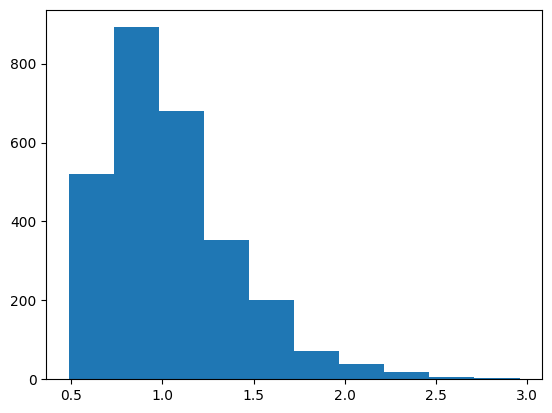

In [7]:
plt.hist(annotations.duration)

## load COGNITION

In [8]:
signals, annotations, signalsMetadata = loadCOGNITIONSpindles(cognipath,returnSignals=True)

In [9]:
signalsMetadata.head()

,filename,channel,subjectId,duration,samplerate,isOriginalSamplerate,database
0,COG001_canal_C3.txt,C3-M2,0001,39600,200,False,COGNITION
1,COG002_canal_C3.txt,C3-M2,0002,39600,200,False,COGNITION
2,COG003_canal_C3.txt,C3-M2,0003,39600,200,False,COGNITION
3,COG004_canal_C3.txt,C3-M2,0004,39600,200,False,COGNITION
4,COG005_canal_C3.txt,C3-M2,0005,39600,200,False,COGNITION


## spindle duration histograms

In [10]:
spindles=annotations[annotations.type=='spindle'].copy()

In [11]:
len(spindles)

2785

In [12]:
#spindles longer than 4 seconds
print(len(spindles[spindles.duration>4])/len(spindles)) #50 parts per million
spindles[spindles.duration>4]

0.0


,subjectId,channel,startTime,stopTime,duration,phase,labelerId,type,samplerate,startInd,stopInd


In [13]:
aux=annotations[["type","labelerId","subjectId"]].groupby(["type","labelerId","subjectId"],as_index=False).size()
px.bar(aux,x="subjectId",y="size",color="labelerId",barmode="group",facet_row="type",title="COGNITION annotations overview")

In [14]:
px.histogram(spindles,x='duration',title="COGNITION spindle duration histogram")

In [15]:
px.histogram(spindles,x='duration',color="subjectId",facet_row="labelerId",title="COGNITION spindle duration histogram by signal")

In [16]:
aux=spindles[['subjectId','startTime']].groupby('subjectId',as_index=False).size()
aux

,subjectId,size
0,0001,214
1,0002,240
2,0003,849
3,0004,419
4,0005,316
5,0006,226
6,0007,372
7,0008,47
8,0009,102


In [17]:
aux=pd.merge(signalsMetadata,aux,on="subjectId")
aux["density"]=aux["size"]/(aux["duration"]/3600)

In [18]:
signalsMetadata

,filename,channel,subjectId,duration,samplerate,isOriginalSamplerate,database
0,COG001_canal_C3.txt,C3-M2,0001,39600,200,False,COGNITION
1,COG002_canal_C3.txt,C3-M2,0002,39600,200,False,COGNITION
2,COG003_canal_C3.txt,C3-M2,0003,39600,200,False,COGNITION
3,COG004_canal_C3.txt,C3-M2,0004,39600,200,False,COGNITION
4,COG005_canal_C3.txt,C3-M2,0005,39600,200,False,COGNITION
5,COG006_canal_C3.txt,C3-M2,0006,39600,200,False,COGNITION
6,COG007_canal_C3.txt,C3-M2,0007,39600,200,False,COGNITION
7,COG008_canal_C3.txt,C3-M2,0008,39600,200,False,COGNITION
8,COG009_canal_C3.txt,C3-M2,0009,39600,200,False,COGNITION


In [19]:
aux["density"]

0    19.454545
1    21.818182
2    77.181818
3    38.090909
4    28.727273
5    20.545455
6    33.818182
7     4.272727
8     9.272727
Name: density, dtype: float64

In [20]:
signals['0009'].shape[0]/200

39600.0

In [21]:
np.mean(aux["density"])

28.131313131313135

In [22]:
np.std(aux["density"])

20.09811156199335

In [23]:
m=np.mean(aux['size'])
s=np.std(aux['size'])

## spindle time

In [24]:
all=[]
for ind, row in signalsMetadata.iterrows():
    labels=excerptAnnotationsToLabels(annotations[annotations.subjectId==row.subjectId],len(signals[row.subjectId]))
    all.append(np.sum(labels)/len(labels))

In [25]:
np.mean(all)

0.008159287317620651

In [26]:
np.std(all)

0.0068825554246562766

In [27]:
all

[0.005891414141414141,
 0.006516287878787879,
 0.025683585858585857,
 0.011525252525252525,
 0.007714393939393939,
 0.004834722222222222,
 0.008224242424242424,
 0.0009359848484848485,
 0.00210770202020202]

In [28]:
signalsMetadata.duration/3600

0    11.0
1    11.0
2    11.0
3    11.0
4    11.0
5    11.0
6    11.0
7    11.0
8    11.0
Name: duration, dtype: float64

### other

In [29]:
signals['0008'].shape[0]/200

39600.0

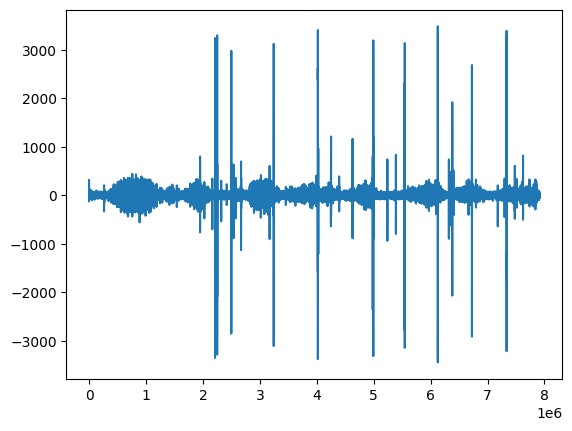

In [30]:
plt.plot(signals['0008'])

In [31]:
aux=loadLabelsVector(['0008'],annotations,signalsMetadata,200)

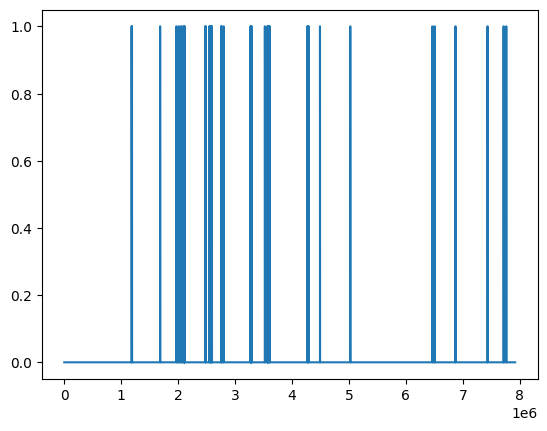

In [32]:
plt.plot(aux)

### Hypnograms

In [68]:
from scipy.io import loadmat

files=os.listdir(cognipath+'/stages')
for file in files:
    aux=loadmat(cognipath+'/stages/'+file)
    stage=aux['stage']
    hypnogram=np.zeros_like(signals['0001'])
    for i in range(stage.shape[0]):
        hypnogram[i*6000:(i+1)*6000]=stage[i]
    dumpPickle(cognipath+'/stages/0'+file[3:-4]+'.pkl',hypnogram)
        

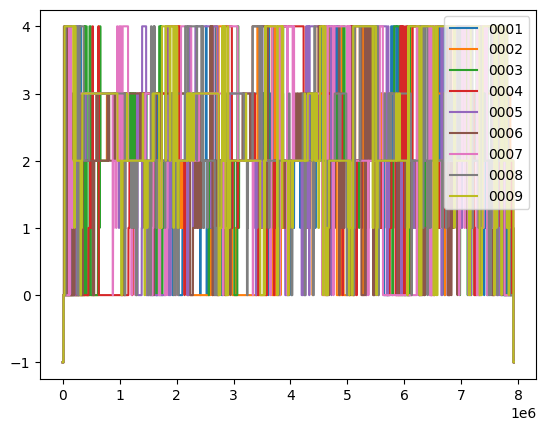

In [74]:
for subject in signalsMetadata.subjectId:
    hypnogram=loadPickle(cognipath+'/stages/'+subject+'.pkl')
    plt.plot(hypnogram)
    
plt.legend(signalsMetadata.subjectId,loc='upper right')